In [41]:
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
df = pd.read_csv('ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])

In [58]:
df

,x,y
0,7.187592,-8.768943
1,0.170888,-25.895562
2,4.167006,-29.062891
3,7.259387,-31.529549
4,5.941430,-30.540759
...,...,...
1472,4.587862,-29.743108
1473,-0.961247,-19.418516
1474,4.247799,-29.460539
1475,-1.417041,-21.391002


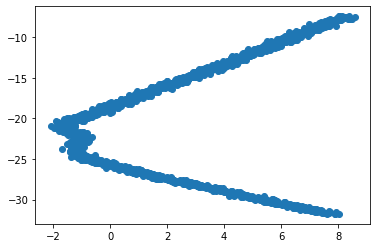

In [63]:
plt.scatter(df['x'], df['y'])